In [14]:
%matplotlib inline

import glob
import itertools
import more_itertools
import nibabel
import nilearn
import numpy as np
import os
import pandas as pd
# import pingouin as pg
import re
import scipy
import sys

from load_confounds import Minimal
from nibabel.nifti1 import Nifti1Image
from nilearn import datasets
from nilearn import image as nimage
from nilearn.input_data import NiftiMasker, NiftiMapsMasker, NiftiSpheresMasker
from numpy import nan as NaN
from matplotlib import pyplot as plt
from nibabel.nifti1 import Nifti1Image
from pathlib import Path
from random import sample
from sklearn.utils import Bunch

# from nilearn.glm.first_level import FirstLevelModel, check_events
# from nilearn.glm.first_level import make_first_level_design_matrix
# from nilearn import plotting as niplot
# from nilearn import image as nimage
# from nilearn.masking import apply_mask
# from nilearn.signal import clean
from tqdm import tqdm
from typing import Union
from cimaq_decoding_utils import trial_fmri
from get_difumo import get_difumo


from get_difumo import get_difumo

#libraries need to be installed in conda environment with pip install

ImportError: cannot import name 'float_factorial' from 'scipy._lib._util' (/home/fnadeau/myenv/lib/python3.7/site-packages/scipy/_lib/_util.py)

In [13]:
! pip install scipy sklearn numpy pandas statsmodels pingouin

In [92]:
os.chdir('/data/simexp/fnadeau/')

In [98]:
from cimaq_decoding_utils import get_fmri_sessions, fetch_fmriprep_session
atlases_dir = '../../nilearn_atlases/difumo_atlases/'
fmriprep_dir = '/data/simexp/cimaq_preproc/fmriprep/'
events_dir = '/data/simexp/fnadeau/CIMAQ_AS_BIDS_4/'

In [99]:
niak_path = Path(os.path.join(os.getcwd(),'niak'))
mist_csv_paths = list(niak_path.rglob('*.csv'))
mist_csv_files = [pd.read_csv(apath) for apath in mist_csv_paths]
# display(*mist_csv_files)
difumo = get_difumo(atlases_dir=atlases_dir, n_dims=64, resolution_mm=3)

IndexError: list index out of range

In [87]:
mist = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
# nilearn.plotting.plot_roi(nimage.load_img(mist.scale444))
nilearn.plotting.find_probabilistic_atlas_cut_coords(nimage.load_img(mist.scale444))

DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a 3D image. See http://nilearn.github.io/manipulating_images/input_output.html.

In [37]:
print(mist.description.decode())

An atlas of multiscale brain parcellations


Content
-------
This work is a derivative from the Cambridge sample found in the [1000
functional connectome project]
(http://fcon_1000.projects.nitrc.org/fcpClassic/FcpTable.html) (Liu et
al., 2009), originally released under Creative Commons -- Attribution
Non-Commercial. It includes group brain parcellations generated from
resting-state functional magnetic resonance images for about 200 young
healthy subjects. Multiple scales (number of networks) are available,
and includes 7, 12, 20, 36, 64, 122, 197, 325, 444. The brain parcellations
have been generated using a method called bootstrap analysis of stable clusters
(BASC, Bellec et al., 2010) and the scales have been selected using a data-driven
method called MSTEPS (Bellec, 2013).


This release more specifically contains the following files:
    :'description': a markdown (text) description of the release.
    :'scale007', 'scale012', 'scale020', 'scale036', 'scale064',
     'scale122', 

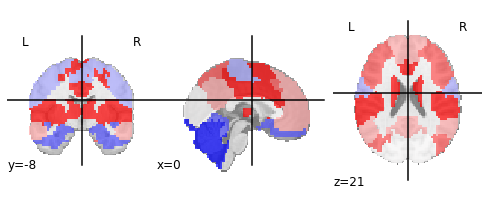

In [31]:
from nilearn import plotting as niplot
niplot.plot_roi(nimage.load_img(mist.scale007),
                cmap=niplot.cm.bwr)


In [23]:
help(datasets.fetch_atlas_basc_multiscale_2015)

Help on function fetch_atlas_basc_multiscale_2015 in module nilearn.datasets.atlas:

fetch_atlas_basc_multiscale_2015(version='sym', data_dir=None, url=None, resume=True, verbose=1)
    Downloads and loads multiscale functional brain parcellations
    
    This atlas includes group brain parcellations generated from
    resting-state functional magnetic resonance images from about
    200 young healthy subjects.
    
    Multiple scales (number of networks) are available, among
    7, 12, 20, 36, 64, 122, 197, 325, 444. The brain parcellations
    have been generated using a method called bootstrap analysis of
    stable clusters called as BASC :footcite:`BELLEC20101126`,
    and the scales have been selected using a data-driven method
    called MSTEPS :footcite:`Bellec2013Mining`.
    
    Note that two versions of the template are available, 'sym' or 'asym'.
    The 'asym' type contains brain images that have been registered in the
    asymmetric version of the MNI brain template (r

In [3]:
sess00 = fetch_fmriprep_session(session=sample(get_fmri_sessions(topdir=fmriprep_dir,
                                                                 events_dir=events_dir,
                                                                 ses_id="V03"), 1)[0])

In [4]:
display(sess00.events, sess00.behav)

,trial_number,trial_type,stim_id,position_correct,response_time,onset,offset,isi,duration,stim_file,stim_category,recognition_response,recognition_responsetime,position_response,position_responsetime,recognition_accuracy,position_accuracy,recognition_performance,ctl_miss_ws_cs
0,4,Ctl,NaN,8.0,1.4,11.6,14.6,5.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctl,Ctl
1,5,Enc,Old58,6.0,1.9,20.1,23.1,0.5,3.0,sporting_hockey stick_old.bmp,sporting,1.0,5.1,6.0,4.4,1.0,1.0,Hit,Cs
2,6,Enc,Old12,5.0,2.0,23.6,26.6,1.0,3.0,animal_siamese cat.bmp,animal,2.0,NaN,NaN,NaN,0.0,NaN,Miss,Miss
3,7,Enc,Old20,6.0,2.5,27.6,30.6,1.0,3.0,food_frenchfries.bmp,food,2.0,NaN,NaN,NaN,0.0,NaN,Miss,Miss
4,8,Enc,Old73,9.0,2.8,31.6,34.6,1.5,3.0,vegie_corn02.bmp,vegie,1.0,4.0,9.0,2.0,1.0,1.0,Hit,Cs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,116,Enc,Old41,6.0,1.9,694.5,697.5,6.0,3.0,musical_accordion_old.bmp,musical,1.0,1.2,6.0,0.6,1.0,1.0,Hit,Cs
113,117,Ctl,NaN,9.0,1.2,703.5,706.5,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ctl,Ctl
114,118,Enc,Old25,5.0,1.7,717.0,720.0,5.0,3.0,food_shellpasta.bmp,food,1.0,3.4,5.0,1.8,1.0,1.0,Hit,Cs
115,119,Enc,Old33,5.0,1.6,725.0,728.0,1.0,3.0,kitchen_peppermill.bmp,kitchen,1.0,2.0,5.0,2.0,1.0,1.0,Hit,Cs


,old_new,stim_file,stim_category,stim_id,recognition_response,recognition_responsetime,position_response,position_responsetime,position_correct,recognition_accuracy,position_accuracy,recognition_performance
0,Old,sporting_mini-trampoline.bmp,sporting,Old61,1,4.1,5.0,4.6,5.0,1.0,1.0,Hit
1,Old,food_shellpasta.bmp,food,Old25,1,3.4,5.0,1.8,5.0,1.0,1.0,Hit
2,New,sporting_flippers.bmp,sporting,New02,2,NaN,NaN,NaN,NaN,1.0,NaN,CR
3,Old,fruit_pineapple_old.bmp,fruit,Old70,1,2.4,9.0,1.5,9.0,1.0,1.0,Hit
4,Old,food_pecan02.bmp,food,Old21,1,2.2,5.0,2.9,8.0,1.0,0.0,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...
112,Old,sporting_americanfootball.bmp,sporting,Old53,2,NaN,NaN,NaN,5.0,0.0,NaN,Miss
113,Old,kitchen_ladle.bmp,kitchen,Old31,1,1.9,6.0,1.0,6.0,1.0,1.0,Hit
114,New,kitchen_baking spatula.bmp,kitchen,New01,2,NaN,NaN,NaN,NaN,1.0,NaN,CR
115,New,fruit_rasberry.bmp,fruit,New10,2,NaN,NaN,NaN,NaN,1.0,NaN,CR


In [5]:
# from cimaq_getbetas2 import sub_tcontrasts1, sub_tcontrasts2, sub_tcontrasts3
# test1 = sub_tcontrasts1(session=sess00)
# test2 = sub_tcontrasts2(session=sess00)
# test3 = sub_tcontrasts3(session=sess00)
# all_contrasts = list(test1)+list(test2)+list(test3)
# contrast_map = pd.DataFrame(all_contrasts, columns=['images', 'names'])

In [6]:
# from get_difumo import get_difumo

# difumo_256 = get_difumo('../../nilearn_atlases/difumo_atlases/', 256, 3)


In [7]:
frame_intervals = [pd.Interval(*item) for item in
                   tuple(zip(sess00.frame_times,
                             sess00.frame_times+2.5))]
trial_ends = (sess00.events.onset+sess00.events.duration+sess00.events.isi).values
trial_intervals = [pd.Interval(*item) for item in
                   tuple(zip(sess00.events.onset.values, trial_ends))]

valid_trial_idx = [frame[0] for frame in enumerate(frame_intervals)
                   if frame[1].left < trial_intervals[-1].left]
bold_by_trial_indx = [[frame[0] for frame in enumerate(frame_intervals)
                       if frame[1].left in trial] for trial in trial_intervals]
bold_by_trial_df = pd.DataFrame(zip(sess00.events.trial_type.values,
                                    sess00.events.recognition_performance.values,
                                    bold_by_trial_indx),
                                columns=['trial_type', 'hit_miss_ctl', 'fmri_frame'])

bold_by_trial_df['trial_labels'] = [[row[1].trial_type]*len(row[1].fmri_frame)
                                    for row in bold_by_trial_df.iterrows()]
bold_by_trial_df['hit_miss_ctl_labels'] = [[row[1].hit_miss_ctl]*len(row[1].fmri_frame)
                                           for row in bold_by_trial_df.iterrows()]
# trial_type_labels = list(more_itertools.flatten(bold_by_trial_df.trial_labels.values))
# hit_miss_ctl_labels = list(more_itertools.flatten(bold_by_trial_df.hit_miss_ctl.values))

In [8]:
hit_miss_ctl_labels = bold_by_trial_df['hit_miss_ctl_labels'][0]
[hit_miss_ctl_labels.extend(lst) for lst in bold_by_trial_df['hit_miss_ctl_labels'][1:]]
len(hit_miss_ctl_labels)

296

In [9]:
enc_ctl_labels = bold_by_trial_df['trial_labels'][0]
[enc_ctl_labels.extend(lst) for lst in bold_by_trial_df['trial_labels'][1:]]
len(enc_ctl_labels)

296

In [10]:
# label_names = difumo_256.labels.difumo_names.values

# labels_masker_params = dict(labels_img=mean_img(difumo_256.maps),
#                             labels=label_names,
#                             background_label=0,
# #                             mask_img=None,
#                             mask_img=sess00.mask_img,
#                             smoothing_fwhm=None,
#                             standardize=True,
#                             standardize_confounds=False,
#                             high_variance_confounds=False,
#                             detrend=False,
#                             low_pass=None, high_pass=None,
#                             t_r=sess00.fmri_img.header.get_zooms()[-1],
#                             dtype=None,
#                             resampling_target='data', strategy='mean',
#                             reports=True)

nifti_masker_params = dict(mask_img=sess00.mask_img,
                            smoothing_fwhm=None,
                            standardize=False,
                            standardize_confounds=False,
                            high_variance_confounds=False,
                            detrend=False,
                            low_pass=None, high_pass=None,
                            t_r=sess00.fmri_img.header.get_zooms()[-1],
                            dtype=None,
                            reports=True)

In [11]:
from nilearn.image import iter_img
niftimasker = NiftiMasker(**nifti_masker_params)
signals = [niftimasker.fit_transform(img) for img in list(iter_img(sess00.fmri_img))]
signals = signals[len(signals)-len(hit_miss_ctl_labels):]
sigs = [sig[-1] for sig in signals]

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

In [13]:
X_enc_ctl, y_enc_ctl = sigs, enc_ctl_labels

X_train, X_test, y_train, y_test = train_test_split(
    X_enc_ctl, y_enc_ctl, # x, y
    test_size = 0.3,
    shuffle = True, # shuffle dataset before splitting
    stratify = y_enc_ctl, # keep distribution of conditions consistent betw. train & test sets
    )

In [14]:
X_B, y_B = sigs, hit_miss_ctl_labels

X_trainB, X_testB, y_trainB, y_testB = train_test_split(
    X_B, y_B, # x, y
    test_size = 0.3,
    shuffle = True, # shuffle dataset before splitting
    stratify = y_B, # keep distribution of conditions consistent betw. train & test sets
    )

In [15]:
cv = KFold(n_splits=4)
subSVC = SVC(**{'C': 1, 'kernel': 'linear', 'tol': 0.05})
# subSVC.fit(X_train, y_train)

In [16]:
y_pred = cross_val_predict(subSVC, X_train, y_train,
                           groups=y_train, cv=10)
# scores
cv_acc = cross_val_score(subSVC, X_train, y_train,
                     groups=y_train, cv=10)
print(cv_acc)

# evaluate overall model performance on training data
overall_acc = accuracy_score(y_pred=y_pred,
                             y_true=y_train)
overall_cr = classification_report(y_pred=y_pred,
                                   y_true=y_train)

print('Accuracy:',overall_acc)
print(overall_cr)

[0.57142857 0.66666667 0.61904762 0.57142857 0.47619048 0.71428571
 0.66666667 0.65       0.75       0.6       ]
Accuracy: 0.6280193236714976
              precision    recall  f1-score   support

         Ctl       0.43      0.38      0.40        69
         Enc       0.71      0.75      0.73       138

    accuracy                           0.63       207
   macro avg       0.57      0.57      0.57       207
weighted avg       0.62      0.63      0.62       207



In [33]:
y_predB = cross_val_predict(subSVC, X_trainB, y_trainB,
                            groups=y_train, cv=10)
# scores
cv_accB = cross_val_score(subSVC, X_trainB, y_trainB,
                     groups=y_trainB, cv=10)
print(cv_accB)

# evaluate overall model performance on training data
overall_accB = accuracy_score(y_pred=y_predB,
                             y_true=y_trainB)
overall_crB = classification_report(y_pred=y_predB,
                                    y_true=y_trainB)

print('Accuracy:',overall_accB)
print(overall_crB)

[0.66666667 0.42857143 0.38095238 0.19047619 0.52380952 0.38095238
 0.47619048 0.4        0.55       0.55      ]
Accuracy: 0.45410628019323673
              precision    recall  f1-score   support

         Ctl       0.42      0.42      0.42        69
         Hit       0.53      0.54      0.54       103
        Miss       0.28      0.26      0.27        35

    accuracy                           0.45       207
   macro avg       0.41      0.41      0.41       207
weighted avg       0.45      0.45      0.45       207



In [18]:
subSVC.fit(X_train, y_train)
len(list(filter(None, subSVC.predict(X_test) == y_test)))/len(y_test)

0.651685393258427

In [19]:
subSVC.fit(X_trainB, y_trainB)
len(list(filter(None, subSVC.predict(X_testB) == y_testB)))/len(y_testB)

0.5955056179775281

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.svm import SVC


# # Set the parameters by cross-validation
# tuned_parameters = [
# #     {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
#     {"kernel": ["linear", "poly"], "C": [0.1, 1], "tol": [0.005, 0.001],
#      "class_weight": ["balanced", None]},    
# #     {"kernel": ["linear", "poly"], "C": [0.1, 1],
# #      "tol": [0.005, 0.001], "class_weight": ["balanced", None]},
# ]

# scores = ["precision", "recall"]

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
#     clf.fit(X_train, y_train)

#     print("Best parameters set found for CIMA-Q:\n")
#     print(f'{clf.best_params_}\n')
#     print("Grid scores for CIMA-Q:\n")
#     means = clf.cv_results_["mean_test_score"]
#     stds = clf.cv_results_["std_test_score"]
#     for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:\n")
#     print("Model trained on CIMA-Q.")
#     print("Scores computed on full evaluation set.\n")
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))

In [ ]:



trial_ends=(sub00.events.onset+abs(sub00.events.onset -
                             sub00.events.offset)+sub00.events.isi).values
trial_intervals=list(itertools.starmap(pd.Interval,
                                       tuple(zip(sub00.events.onset, trial_ends))))
frame_ends=pd.Series(sub00.frame_times)+2.5
frame_intervals=np.array(list(itertools.starmap(pd.Interval,
                                       tuple(zip(sub00.frame_times, frame_ends)))))


sub00.vectors = trial_fmri(sub00.cleaned_fmri, sub00.events)

sub00.sessions=pd.concat(list(pd.DataFrame(
                   itertools.repeat(row[1], len(sub00.vectors.fmri_frames.iloc[row[0]])))
                              for row in sub00.events.iterrows())).reset_index(drop=True)

sub00.sessions_ret = pd.concat(list(pd.DataFrame(
                         itertools.repeat(row[1], len(sub00.vectors.fmri_frames.iloc[row[0]])))
                              for row in sub00.behav.iterrows())).reset_index(drop=True)
# sub00.sessions.set_axis(sub00.events.columns.tolist(), axis=1)
sub00.indexed_fmri = index_img(sub00.cleaned_fmri, sub00.sessions.index)


In [ ]:


# ``load_confounds`` got that covered!

# For decoding, standardizing is often very important
# nifti_masker = NiftiMasker(mask_img=mask_img, sessions=session,
#                            standardize=True, memory='nilearn_cache',
#                            memory_level=1)



#/difumo_atlases/256/3mm/maps.nii.gz'

difumo_256 = get_difumo('../../nilearn_atlases/difumo_atlases/', 256, 3)


# Smaller brain area: faster and quite likely predictive from theory
loc_index = difumo_256.labels.loc[difumo_256.labels.difumo_names.str.match(
                re.compile('lateral occipital', re.I))].index
loc_maps = nilearn.image.index_img(difumo_256.maps, loc_index)

sub00.spheresmasker = NiftiSpheresMasker(tuple(map(tuple,difumo_256.labels[['gm','wm','csf']])),
                                        radius=None, allow_overlap=True,
                                        **sub00.masker_defs)

sub00.mskmapsmasker = NiftiMapsMasker(loc_maps, mask_img=sub00.mask_img,
                                   resampling_target='mask',
                                   allow_overlap=True, **sub00.masker_defs)

sub00.dmapsmasker = NiftiMapsMasker(loc_maps, mask_img=sub00.mask_img,
                                   resampling_target='data',
                                   allow_overlap=True, **sub00.masker_defs)

sub00.regmasker = NiftiMasker(target_affine=sub00.cleaned_fmri.affine,
                              mask_strategy='whole-brain-template',
                              **sub00.masker_defs)

sub00.mskmaps_sig = sub00.mskmapsmasker.fit_transform(sub00.indexed_fmri)
sub00.dmaps_sig = sub00.dmapsmasker.fit_transform(sub00.indexed_fmri)
# fmri_masked = sub00.regmasker.fit_transform(sub00.indexed_fmri)

# from sklearn.feature_selection import f_classif

# f_values, p_values = f_classif(fmri_masked, y)
# p_values = -np.log10(p_values)
# p_values[p_values > 10] = 10
# p_unmasked = get_data(sub00.regmasker.inverse_transform(p_values))

In [ ]:
import nilearn.decoding

from nilearn.image import new_img_like, load_img, get_data

# Cross-validation scheme definition:
    # Here we use a KFold cross-validation on the session.
    # This corresponds to splitting the samples in 4 folds
    # and make 4 runs using each fold as a test
    # set once and the others as learning sets

# Unused yet: groups=stim_categories
stim_categories = sub00.sessions.stim_category.replace(
                      {'K':'kitchen'}).str.lower().fillna('Ctl').values

cv = KFold(n_splits=4)

estimator = LinearSVC(tol=50e-3,
#                       penalty='l2',
#                       loss='hinge',
                      max_iter=1000,
                      class_weight='balanced',
                      fit_intercept=True)

# estimator.fit(sub00.indexed_fmri.get_fdata(), y)
# pp_svc = LinearSVCPure(estimator)
# pp_svc = convert_estimator(SVC())
# lreg = LinearRegression(n_jobs=8).fit(get_data(sub00.indexed_fmri).astype('uint8'), y)
# estimator = LinearClassifierMixinPure(lreg)
y = sub00.sessions.trial_type.values


# The radius is the one of the Searchlight sphere that will scan the volume

###################################################
# Set to 4 since cubic voxels were smoothed to 8mm?


searchlight = nilearn.decoding.SearchLight(mask_img=sub00.dmapsmasker.mask_img,
#                                            sub00.mask_img,
                                           radius=4.0,
                                           estimator=estimator,
                                           n_jobs=10, cv=cv)
searchlight.fit(sub00.indexed_fmri, y)
